# Use MLP to predict the results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from keras.models import Sequential
# from keras.utils import np_utils
# from keras.layers.core import Dense, Activation, Dropout

# import pandas as pd
# import numpy as np

# # Read data
# train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
# labels = train.iloc[:,0].values.astype('int32')
# X_train = (train.iloc[:,1:].values).astype('float32')
# X_test = (pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv').values).astype('float32')

# # convert list of labels to binary class matrix
# y_train = np_utils.to_categorical(labels) 

# # pre-processing: divide by max and substract mean
# scale = np.max(X_train)
# X_train /= scale
# X_test /= scale

# mean = np.std(X_train)
# X_train -= mean
# X_test -= mean

# input_dim = X_train.shape[1]
# nb_classes = y_train.shape[1]

# # Here's a Deep Dumb MLP (DDMLP)
# model = Sequential()
# model.add(Dense(128, input_dim=input_dim))
# model.add(Activation('relu'))
# model.add(Dropout(0.15))
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.15))
# model.add(Dense(nb_classes))
# model.add(Activation('softmax'))

# # we'll use categorical xent for the loss, and RMSprop as the optimizer
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# print("Training...")
# model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=2)

# print("Generating test predictions...")
# preds = model.predict(X_test, verbose=0)
# classes_x=np.argmax(preds,axis=1)

# def write_preds(preds, fname):
#     pd.DataFrame({"ImageId": list(range(1,len(preds)+1)), "Label": classes_x}).to_csv(fname, index=False, header=True)

# write_preds(preds, "keras-mlp.csv")
# print("Done!")

# Use CNN to predict the results

## Import necessary tools

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
# Could omit plt.show()
%matplotlib inline 

np.random.seed(2)

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

## Data Preparation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

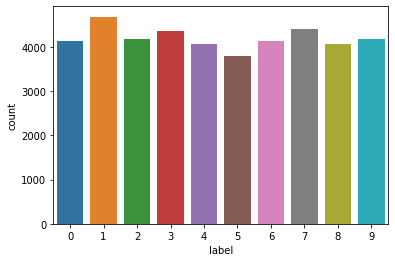

In [ ]:
# Read data
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

x_train = train.iloc[:,1:]
y_train = train['label']

sns.countplot(y_train) # The data labels are Evenly distributed
y_train.value_counts() 

In [ ]:
# Check Train data set hasn't include Null value
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
# Check Test data set hasn't include Null value
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## Use Normalization & Reshape

In [ ]:
x_train /= 255
test /= 255
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
x_train.shape # (42000,784) -> (42000,28,28,1)

(42000, 28, 28, 1)

## Let label to be a one hot vector

In [ ]:
y_train = to_categorical(y_train, num_classes = 10) # 0 ~ 9
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## Training Phase

In [ ]:
random_seed = 2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed) # From Sklearn

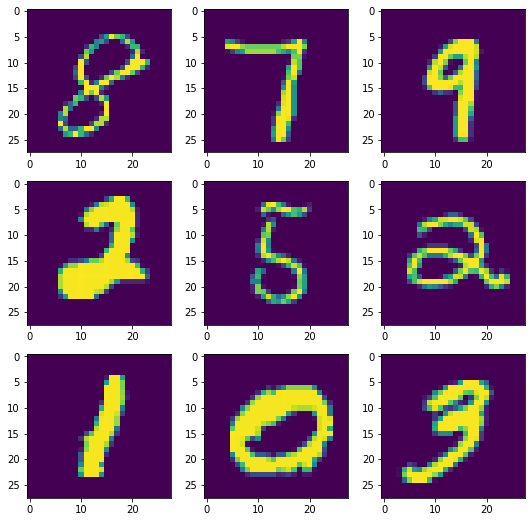

In [ ]:
x_train[0].shape
f, axarr = plt.subplots(3,3,figsize=(9, 9))
# Show some images in training data
for i in range(3):
  for j in range(3):
    axarr[i,j].imshow(x_train[i*10+j][:,:,0])      

In [ ]:
model = Sequential()
# Model Structure: [[Conv + Relu]*2 -> MaxPool -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Classification
# Parameters Setting
# filters ususally are the multiple of four
# padding="same" results in padding with zeros ,so the input dim could equal to the output dim
# Second best model -> filters = 32, kernel_size(5,5)
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2))) # use MaxPool2D to find the maximum value and get the feature maps with dimension reduction
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# In order to reduce the learning rate
from keras.callbacks import ReduceLROnPlateau
LR_function=ReduceLROnPlateau(monitor='val_accuracy',
                             patience=3, # Modified LR when val_accuracy not declined within 3 epochs
                             verbose=1,
                             factor=0.5, # LR reduce to 0.5
                             min_lr=0.00001 # This is the minimum LR
                             )

# We'll use categorical_crossentropy for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Epochs 40 batch_size 100 best accuracy 0.99125 -> 0.99203
epochs = 40
batch_size = 100
#history = model.fit_generator(x_train, y_train, epochs=epochs, validation_data=(x_val,y_val), verbose=2, steps_per_epoch=x_train.shape[0] // batch_size)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=2, callbacks=[LR_function])

Epoch 1/40
378/378 - 19s - loss: 0.2682 - accuracy: 0.9132 - val_loss: 0.0581 - val_accuracy: 0.9807 - lr: 0.0010 - 19s/epoch - 49ms/step
Epoch 2/40
378/378 - 6s - loss: 0.0832 - accuracy: 0.9734 - val_loss: 0.0522 - val_accuracy: 0.9831 - lr: 0.0010 - 6s/epoch - 16ms/step
Epoch 3/40
378/378 - 6s - loss: 0.0609 - accuracy: 0.9818 - val_loss: 0.0367 - val_accuracy: 0.9864 - lr: 0.0010 - 6s/epoch - 16ms/step
Epoch 4/40
378/378 - 6s - loss: 0.0454 - accuracy: 0.9864 - val_loss: 0.0324 - val_accuracy: 0.9912 - lr: 0.0010 - 6s/epoch - 16ms/step
Epoch 5/40
378/378 - 6s - loss: 0.0421 - accuracy: 0.9869 - val_loss: 0.0301 - val_accuracy: 0.9917 - lr: 0.0010 - 6s/epoch - 16ms/step
Epoch 6/40
378/378 - 6s - loss: 0.0350 - accuracy: 0.9887 - val_loss: 0.0279 - val_accuracy: 0.9917 - lr: 0.0010 - 6s/epoch - 16ms/step
Epoch 7/40
378/378 - 6s - loss: 0.0297 - accuracy: 0.9906 - val_loss: 0.0285 - val_accuracy: 0.9917 - lr: 0.0010 - 6s/epoch - 16ms/step
Epoch 8/40

Epoch 00008: ReduceLROnPlateau red

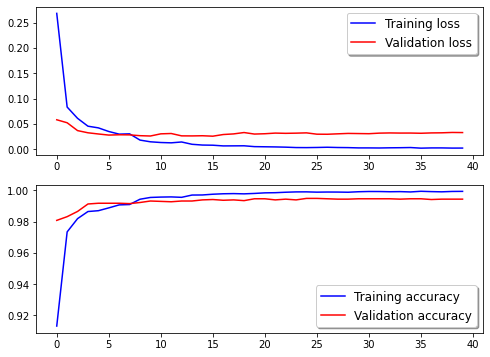

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1,figsize=(8,6))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True, fontsize="large") # Set fontsize="large" to avoid the letter t & r  overlap

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True, fontsize="large") # Set fontsize="large" to avoid the letter t & r  overlap

In [ ]:
# predict results
results = model.predict(test)
print(results)
# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
print(results)
results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
print(submission)
submission.to_csv("cnn_mnist_datagen.csv",index=False)

[[1.5718191e-20 8.3045767e-21 1.0000000e+00 ... 1.0292098e-19
  3.1482590e-17 4.7670257e-21]
 [1.0000000e+00 4.4004441e-21 5.2829540e-16 ... 1.1161638e-15
  6.1945174e-17 6.5159243e-14]
 [2.7682714e-22 1.9218300e-16 5.2533719e-16 ... 2.8023022e-15
  1.8651745e-10 1.0000000e+00]
 ...
 [4.2599802e-30 7.5782639e-22 4.5324043e-24 ... 1.1868212e-18
  3.5240738e-21 2.1519923e-18]
 [6.8122797e-17 1.7083144e-15 2.3955100e-15 ... 1.3258237e-11
  2.8429416e-12 9.9999988e-01]
 [1.1251280e-23 3.1275427e-22 1.0000000e+00 ... 2.4105785e-24
  4.5449755e-16 1.6719478e-21]]
[2 0 9 ... 3 9 2]
       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]
